# Convolutional Neural Network 

## 목적 : DNA Sequence 를 통해 Host species 예측/분류

#### * 입력 데이터 : DNA Sequence onehot vector = [batch_size, sequence_length,onehot value(type)] = [300, 2429, 4]
#### * 라벨 데이터 : Host species onehot vector = [batch_size, species_length,onehot value(type)] = [300, 1, 11]
#### * 출력 데이터 : Probability of Host species prediction = probability of each 11 species , size : [1,11] 

### Convolution neural network : 
    
    conv1 = tf.layers.conv1d(features['sequence'], filters=128, kernel_size=24, padding="SAME")
    maxpool = tf.layers.max_pooling1d(conv1,2429,strides=2429,padding='valid')
    fc = tf.layers.dense(maxpool, 32)
    out = tf.reshape(tf.layers.dense(fc,11), [-1, 11])


    

<img src='./images/cnn.jpg'/>

In [4]:
import tensorflow as tf 
import numpy as np 
import csv 
import os 
import re
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt


tf.logging.set_verbosity(tf.logging.INFO)
tf.reset_default_graph()

In [2]:
def parser(serialized_example):
    features = {'sequence': tf.FixedLenFeature([2429], tf.int64), 
            'species': tf.FixedLenFeature([1], tf.int64)}

    parsed_feature = tf.parse_single_example(serialized_example, features)
    sequence = tf.cast(parsed_feature['sequence'], tf.int32)
    species = tf.cast(parsed_feature['species'], tf.int32)
    return sequence, species



In [3]:
def input_fn_train(): 
    
    ap = re.compile('dataset') # 발췌할 문자열 기입
    file_dir= './' # 데이터 경로 
    files = os.listdir(file_dir) # 경로에 해당하는 전체 파일들 
      
    train_data_all = list(filter(ap.search, files)) # 전체 파일들 중 발췌대상 문자열과 일치하는 파일들을 list 형태로 (데이터셋 10개)
    
    print("train:", train_data_all)
    
    # 발췌된 전체 train_dataset 의 리스트 중 하나씩 빼온 것이 train_data. 이것이 데이터경로와 join 되어 filename 형성 
    filename = [os.path.join(file_dir, train_data) for train_data in train_data_all]
    filename.sort() 
    filename = filename[:8]
    print("filename1:",filename)
    dataset = tf.contrib.data.TFRecordDataset(filename).map(parser)
    dataset = dataset.batch(300)
    itr = dataset.make_one_shot_iterator()

    sequence, species  = itr.get_next()

    print("species:",species.shape)
    print("sequence:",sequence.shape)
    train_data = tf.one_hot(indices=sequence, depth=4)# depth 가 가로 길이 (종류)
    train_label =tf.reshape(tf.one_hot(indices=species,depth=11,axis=1),[-1,11])
    print("train_data:",train_data.shape)
    print("train_label:",train_label.shape)

    return {'sequence': train_data}, train_label


def input_fn_pred(): 

    path = "./11_species_1.csv"
    data = pd.read_csv(path)
    
    label = data["species"]
    feature = data.drop("species", axis=1)

    print("label:",label.shape)
    print("feature:",feature.shape)

    # making one-hot vector 
    one_hot_feature= np.eye(4)

    lookup = np.zeros(shape=[5,4])
    lookup[1:5]=one_hot_feature

    onehot_feature =lookup[feature]
    print("onehot_Feature:",type(onehot_feature))

    
    # making one-hot vector 
    one_hot_label= np.eye(11)

    lookup = np.zeros(shape=[12,11])
    lookup[1:12]=one_hot_label

    onehot_label=lookup[label]
    print("onehot_label:",type(onehot_label))
    print("onehot_feature_dtype:",type(onehot_feature))

    return onehot_feature


def input_fn_test():
    
    p = re.compile('dataset') # 발췌할 문자열 기입
    file_dir= './' # 데이터 경로 
    files = os.listdir(file_dir) # 경로에 해당하는 전체 파일들 
    test_data_all = list(filter(p.match, files)) # 전체 파일들 중 발췌대상 문자열과 일치하는 파일들을 list 형태로 (데이터셋 10개)
    
   
    # 발췌된 전체 train_dataset 의 리스트 중 하나씩 빼온 것이 train_data. 이것이 데이터경로와 join 되어 filename 형성 
    filename = [os.path.join(file_dir, train_data) for train_data in test_data_all]
    filename.sort()  
    filename = filename[8:]
    print("filename2:",filename)
    dataset = tf.contrib.data.TFRecordDataset(filename).map(parser)
    dataset = dataset.batch(300)
    itr = dataset.make_one_shot_iterator()

    sequence, species  = itr.get_next()

    test_data = tf.one_hot(indices=sequence, depth=4)# depth 가 가로 길이 (종류)
    test_label = tf.reshape(tf.one_hot(indices=species,depth=11,axis=1),[-1,11])
    return {'sequence': test_data}, test_label


In [4]:
def model_fn(features, labels, mode): 

    """ model function for estimator """ 
    train_op = None 
    loss = None 
    val_metric_ops = None
    
    
    if labels is not None:
        labels_dim = int(labels.shape[-1])


    # filters = # of kernels ,  kernel_size = window size 
    conv1 = tf.layers.conv1d(features['sequence'], filters=128, kernel_size=24, padding="SAME")
    print("conv1:",conv1.shape)
    maxpool = tf.layers.max_pooling1d(conv1,2429,strides=2429,padding='valid')
    print("maxpool:",maxpool.shape)
    fc = tf.layers.dense(maxpool, 32)
    print("fc:",fc.shape)
    out = tf.reshape(tf.layers.dense(fc,11), [-1, 11])
    print("out:",out.shape)

    # mode = prediction
    if mode == tf.estimator.ModeKeys.PREDICT: 
        return tf.estimator.EstimatorSpec( 
            mode=mode, 
            predictions={
                "prob":tf.nn.softmax(out)})
            
    # mode = training
    else: 
        global_step = tf.train.get_global_step() 
        loss = tf.losses.softmax_cross_entropy(labels, out) 
        train_op = tf.train.GradientDescentOptimizer(1e-2).minimize(loss, global_step) 
        accuracy = tf.metrics.accuracy(labels, tf.round(tf.nn.softmax(out))) 
        eval_metric_ops = {"acc": accuracy} 
        
        tf.summary.scalar('Loss',loss)
        tf.summary.scalar('Accuracy', accuracy[0])
        

        return tf.estimator.EstimatorSpec( 
            mode=mode, 
            train_op=train_op, 
            loss=loss, 
            eval_metric_ops=eval_metric_ops) 

In [ ]:
config = tf.contrib.learn.RunConfig(save_checkpoints_steps=5,save_checkpoints_secs=None,save_summary_steps=5)
est = tf.estimator.Estimator(model_fn, model_dir='./check_cnn/',config=config) 

print('config written')
onehot_feat = input_fn_pred()

onehot_feat = onehot_feat.astype(np.float32)
print("one hot encoding")

print('debugging: {}'.format(onehot_feat))

sequence = {'sequence': onehot_feat}

print('sequence: {}'.format(sequence))
input_fn = tf.estimator.inputs.numpy_input_fn(sequence,shuffle=False)


print('input function: {}'.format(input_fn))
est.train(input_fn_train,steps=75) 
est.evaluate(input_fn_test,steps=1) 

pred = est.predict(input_fn,predict_keys='prob')
print("pred: {}".format(pred))

### Result of CNN trainig

#### * training step : 75 
#### * accuracy : 82.03 %
#### * loss : 1.7103

<img src='./images/loss.jpg'/>

### Probability of prediction

In [6]:
result =[]
for i in pred:
    print(i['prob'])
    result.append(i['prob'])

conv1: (?, 2429, 128)
maxpool: (?, 1, 128)
fc: (?, 1, 32)
out: (?, 11)
INFO:tensorflow:Restoring parameters from ./check_cnn/model.ckpt-226
[ 0.01063557  0.3286601   0.22248106  0.15891849  0.07249931  0.06277035
  0.04967459  0.04242299  0.02063865  0.0195712   0.01172766]


### Prediction of host species

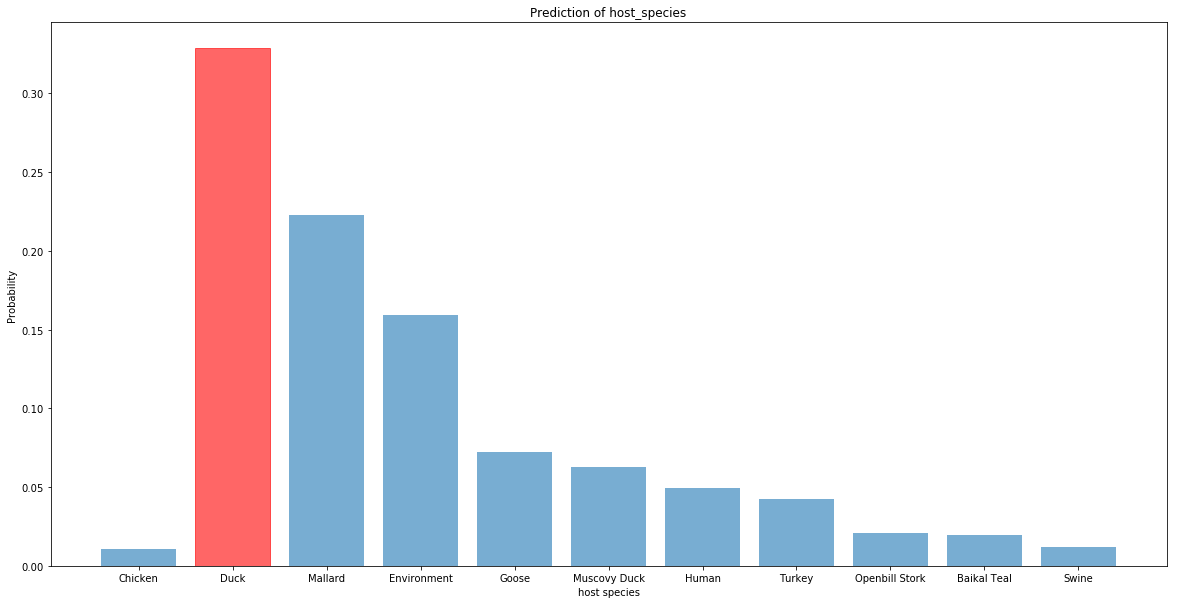

In [8]:
a_result = result[0]

# plotting
plt.figure(3, figsize=(20,10))
x_axis = [i for i in range(11)]
y_axis = a_result

opacity = 0.6
bar = plt.bar(x_axis, y_axis,alpha=opacity)
bar[1].set_color('r')

plt.xlabel('host species')
plt.ylabel('Probability')
plt.title('Prediction of host_species')
plt.xticks(x_axis, ('Chicken', 'Duck', 'Mallard', 'Environment', 'Goose','Muscovy Duck','Human','Turkey','Openbill Stork','Baikal Teal','Swine') )
plt.show()

### 실제 데이터 값과 비교 : 실제 host species 값 ( 2 = Duck),  CNN 예측 host species 값 ( 2 = Duck, probability = 0.3286601)

<img src='./images/excel.jpg'/>

dataset 에서 label로 사용된 host species index 

In [ ]:
"IRD:Chicken/Avian", "1"
"IRD:Duck/Avian", "2"
"IRD:Mallard/Avian", "3"
"IRD:Environment", "4"
"IRD:Goose/Avian", "5"
"IRD:Muscovy Duck/Avian", "6"
"IRD:Human", "7"
"IRD:Turkey/Avian", "8" 
"IRD:Openbill Stork/Avian", "9"
"IRD:Baikal Teal/Avian", "10"
"IRD:Swine", "11"